# 多尺度目标检测
:label:`sec_multiscale-object-detection`

在 :numref:`sec_anchor` 中，我们以输入图像的每个像素为中心，生成了多个锚框。
基本而言，这些锚框代表了图像不同区域的样本。
然而，如果为每个像素都生成的锚框，我们最终可能会得到太多需要计算的锚框。
想象一个 $561 \times 728$ 的输入图像，如果以每个像素为中心生成五个形状不同的锚框，就需要在图像上标记和预测超过 200 万个锚框 ($561 \times 728 \times 5$)。

## 多尺度锚框
:label:`subsec_multiscale-anchor-boxes`

你可能会意识到，减少图像上的锚框数量并不困难。
比如，我们可以在输入图像中均匀采样一小部分像素，并以它们为中心生成锚框。
此外，在不同尺度下，我们可以生成不同数量和不同大小的锚框。
直观地说，比起较大的目标，较小的目标在图像上出现的可能性更多样。
例如，$1 \times 1$、$1 \times 2$ 和 $2 \times 2$ 的目标可以分别以 4、2 和 1 种可能的方式出现在 $2 \times 2$ 图像上。
因此，当使用较小的锚框检测较小的物体时，我们可以采样更多的区域，而对于较大的物体，我们可以采样较少的区域。 

为了演示如何在多个尺度下生成锚框，让我们先读取一张图像。
它的高度和宽度分别为 561 和 728 像素。


In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

img = d2l.plt.imread('../img/catdog.jpg')
h, w = img.shape[:2]
h, w

(561, 728)

回想一下，在 :numref:`sec_conv_layer` 中，我们将卷积图层的二维数组输出称为特征图。
通过定义特征图的形状，我们可以确定任何图像上均匀采样锚框的中心。 

`display_anchors` 函数定义如下。
我们[**在特征图 (`fmap`) 上生成锚框 (`anchors`)，每个单位（像素）作为锚框的中心**]。
由于锚框中的 $(x, y)$ 轴坐标值 (`anchors`) 已经被除以特征图(`fmap`)的宽度和高度 ，因此这些值介于 0 和 1 之间，表示特征图中锚框的相对位置。 

由于锚框 (`anchors`) 的中心分布于特征图 (`fmap`) 上的所有单位，因此这些中心必须根据其相对空间位置在任何输入图像上 *均匀* 分布。
更具体地说，给定特征图的宽度和高度 `fmap_w` 和 `fmap_h` ，以下函数将 *均匀地* 对任何输入图像中 `fmap_h` 行和 `fmap_w` 列中的像素进行采样。
以这些均匀采样的像素为中心，将会生成大小为 `s`（假设列表 `s` 的长度为 1）且宽高比（ `ratios` ）不同的锚框。


In [2]:
def display_anchors(fmap_w, fmap_h, s):
    d2l.set_figsize()
    # 前两个维度上的值不影响输出
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = d2l.multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img).axes, anchors[0] * bbox_scale)

首先，让我们考虑[**探测小目标**]。
为了在显示时更容易分辨，在这里具有不同中心的锚框不会重叠：
锚框的尺度设置为 0.15，特征图的高度和宽度设置为 4。
我们可以看到，图像上 4 行和 4 列的锚框的中心是均匀分布的。


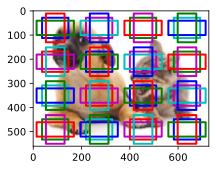

In [3]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

然后，我们[**将特征图的高度和宽度减小一半，然后使用较大的锚框来检测较大的目标**]。
当尺度设置为 0.4 时，一些锚框将彼此重叠。


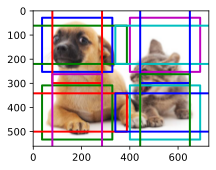

In [4]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

最后，我们进一步[**将特征图的高度和宽度减小一半，然后将锚框的尺度增加到0.8**]。
此时，锚框的中心即是图像的中心。


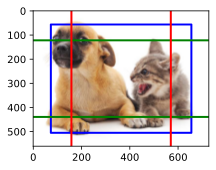

In [5]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

## 多尺度检测

既然我们已经生成了多尺度的锚框，我们就将使用它们来检测不同尺度下各种大小的目标。
下面，我们介绍一种基于 CNN 的多尺度目标检测方法，将在 :numref:`sec_ssd` 中实现。 

在某种规模上，假设我们有 $c$ 张形状为 $h \times w$ 的特征图。
使用 :numref:`subsec_multiscale-anchor-boxes` 中的方法，我们生成了 $hw$ 组锚框，其中每组都有 $a$ 个中心相同的锚框。
例如，在 :numref:`subsec_multiscale-anchor-boxes` 实验的第一个尺度上，给定 10 个（通道数量）$4 \times 4$ 的特征图，我们生成了 16 组锚框，每组包含 3 个中心相同的锚框。
接下来，每个锚框都根据真实值边界框来标记了类和偏移量。
在当前尺度下，目标检测模型需要预测输入图像上 $hw$ 组锚框类别和偏移量，其中不同组锚框具有不同的中心。

假设此处的 $c$ 张特征图是 CNN 基于输入图像的正向传播算法获得的中间输出。
既然每张特征图上都有 $hw$ 个不同的空间位置，那么相同空间位置可以看作含有 $c$ 个单元。
根据 :numref:`sec_conv_layer` 中对感受野的定义，特征图在相同空间位置的 $c$ 个单元在输入图像上的感受野相同：
它们表征了同一感受野内的输入图像信息。
因此，我们可以将特征图在同一空间位置的 $c$ 个单元变换为使用此空间位置生成的 $a$ 个锚框类别和偏移量。
本质上，我们用输入图像在某个感受野区域内的信息，来预测输入图像上与该区域位置相近的锚框类别和偏移量。 

当不同层的特征图在输入图像上分别拥有不同大小的感受野时，它们可以用于检测不同大小的目标。
例如，我们可以设计一个神经网络，其中靠近输出层的特征图单元具有更宽的感受野，这样它们就可以从输入图像中检测到较大的目标。 


## 小结

* 在多个尺度下，我们可以生成不同尺寸的锚框来检测不同尺寸的目标。
* 通过定义特征图的形状，我们可以决定任何图像上均匀采样的锚框的中心。
* 我们使用输入图像在某个感受野区域内的信息，来预测输入图像上与该区域位置相近的锚框类别和偏移量。


## 练习

1. 在 :numref:`subsec_multiscale-anchor-boxes` 中的实验里的第一个尺度（`fmap_w=4, fmap_h=4`）下，生成可能重叠的均匀分布的锚框。
1. 给定形状为 $1 \times c \times h \times w$ 的特征图变量，其中 $c$ 、 $h$ 和 $w$ 分别是特征图的通道数、高度和宽度。你怎样才能将这个变量转换为锚框类别和偏移量？输出的形状是什么？


[Discussions](https://discuss.d2l.ai/t/2948)
